<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# NRPy+'s Reference Metric Interface

## Author: Zach Etienne
### Formatting improvements courtesy Brandon Clark

### NRPy+ Source Code for this module: [reference_metric.py](../edit/reference_metric.py)

## Introduction:
### Why use a reference metric? Benefits of choosing the best coordinate system for the problem

When solving a partial differential equation on the computer, it is useful to first pick a coordinate system well-suited to the geometry of the problem. For example, if we are modeling a spherically-symmetric star, it would be hugely wasteful to model the star in 3-dimensional Cartesian coordinates ($x$,$y$,$z$). This is because in Cartesian coordinates, we would need to choose high sampling in all three Cartesian directions. If instead we chose to model the star in spherical coordinates  ($r$,$\theta$,$\phi$), so long as the star is centered at $r=0$, we would not need to model the star with more than one point in the $\theta$ and $\phi$ directions!

A similar argument holds for stars that are *nearly* spherically symmetric. Such stars may exhibit density distributions that vary slowly in $\theta$ and $\phi$ directions (e.g., isolated neutron stars or black holes). In these cases the number of points needed to sample the angular directions will still be much smaller than in the radial direction.

Thus choice of an appropriate reference metric may directly mitigate the [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follow

1. [Step 1](#define_ref_metric): Defining a reference metric, [`reference_metric.py`](../edit/reference_metric.py)
1. [Step 2](#define_geometric): Defining geometric quantities, **`ref_metric__hatted_quantities()`**
1. [Step 3](#prescribed_ref_metric): Prescribed reference metrics in [`reference_metric.py`](../edit/reference_metric.py)
    1. [Step 3.a](#sphericallike): Spherical-like coordinate systems
        1. [Step 3.a.i](#spherical): **`reference_metric::CoordSystem = "Spherical"`**
        1. [Step 3.a.ii](#sinhspherical): **`reference_metric::CoordSystem = "SinhSpherical"`**
        1. [Step 3.a.iii](#sinhsphericalv2): **`reference_metric::CoordSystem = "SinhSphericalv2"`**
    1. [Step 3.b](#cylindricallike): Cylindrical-like coordinate systems
        1. [Step 3.b.i](#cylindrical): **`reference_metric::CoordSystem = "Cylindrical"`**
        1. [Step 3.b.ii](#sinhcylindrical): **`reference_metric::CoordSystem = "SinhCylindrical"`**
        1. [Step 3.b.iii](#sinhcylindricalv2): **`reference_metric::CoordSystem = "SinhCylindricalv2"`**
    1. [Step 3.c](#cartesianlike): Cartesian-like coordinate systems
        1. [Step 3.c.i](#cartesian): **`reference_metric::CoordSystem = "Cartesian"`**
    1. [Step 3.d](#prolatespheroidal): Prolate spheroidal coordinates
        1. [Step 3.d.i](#symtp): **`reference_metric::CoordSystem = "SymTP"`**
        1. [Step 3.d.ii](#sinhsymtp): **`reference_metric::CoordSystem = "SinhSymTP"`**
1. [Step 4](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='define_ref_metric'></a>

# Step 1: Defining a reference metric, [`reference_metric.py`](../edit/reference_metric.py) \[Back to [top](#toc)\]
$$\label{define_ref_metric}$$

***Note that currently only orthogonal reference metrics of dimension 3 or fewer are supported. This can be extended if desired.***

NRPy+ assumes all curvilinear coordinate systems map directly from a uniform, Cartesian numerical grid with coordinates $(x,y,z)$=(`xx[0]`,`xx[1]`,`xx[2]`). Thus when defining reference metrics, all defined coordinate quantities must be in terms of the `xx[]` array. As we will see, this adds a great deal of flexibility

For example,  [**reference_metric.py**](../edit/reference_metric.py) requires that the *orthogonal coordinate scale factors* be defined. As described [here](https://en.wikipedia.org/wiki/Curvilinear_coordinates), the $i$th scale factor is the positive root of the metric element $g_{ii}$. In ordinary spherical coordinates $(r,\theta,\phi)$, with line element $ds^2 = g_{ij} dx^i dx^j = dr^2+ r^2 d \theta^2 + r^2 \sin^2\theta \ d\phi^2$, we would first define
* $r = xx_0$
* $\theta = xx_1$
* $\phi = xx_2$,

so that the scale factors are defined as
* `scalefactor_orthog[0]` = $1$
* `scalefactor_orthog[1]` = $r$
* `scalefactor_orthog[2]` = $r \sin \theta$

Here is the corresponding code:

In [1]:
import sympy as sp
import NRPy_param_funcs as par
import reference_metric as rfm

r = rfm.xx[0]
th = rfm.xx[1]
ph = rfm.xx[2]

rfm.scalefactor_orthog[0] = 1
rfm.scalefactor_orthog[1] = r
rfm.scalefactor_orthog[2] = r*sp.sin(th)

# Notice that the scale factor will be given 
#    in terms of the fundamental Cartesian
#    grid variables, and not {r,th,ph}:
print("r*sin(th) = "+str(rfm.scalefactor_orthog[2]))

r*sin(th) = xx0*sin(xx1)


Next suppose we wish to modify our radial coordinate $r(xx_0)$ to be an exponentially increasing function, so that our numerical grid $(xx_0,xx_1,xx_2)$ will map to a spherical grid with radial grid spacing ($\Delta r$) that *increases* with $r$. Generally we will find it useful to define $r(xx_0)$ to be an odd function, so let's choose

$$r(xx_0) = a \sinh(xx_0/s),$$

where $a$ is an overall radial scaling factor, and $s$ denotes the scale (in units of $xx_0$) over which exponential growth will take place. In our implementation below, note that we use the relation

$$\sinh(x) = \frac{e^x - e^{-x}}{2},$$

as SymPy finds it easier to evaluate exponentials than hyperbolic trigonometric functions.

In [2]:
a,s = sp.symbols('a s',positive=True)
xx0_rescaled = rfm.xx[0] / s
r = a*(sp.exp(xx0_rescaled) - sp.exp(-xx0_rescaled))/2

# Must redefine the scalefactors since 'r' has been updated!
rfm.scalefactor_orthog[0] = 1
rfm.scalefactor_orthog[1] = r
rfm.scalefactor_orthog[2] = r*sp.sin(th)

print(rfm.scalefactor_orthog[2])

a*(exp(xx0/s) - exp(-xx0/s))*sin(xx1)/2


Often we will find it useful to also define the appropriate mappings from (`xx[0]`,`xx[1]`,`xx[2]`) to Cartesian coordinates (for plotting purposes) and ordinary spherical coordinates (e.g., in case initial data when solving a PDE are naturally written in spherical coordinates). For this purpose, reference_metric.py also declares lists **`xxCart[]`** and **`xxSph[]`**, which in this case are defined as

In [3]:
rfm.xxSph[0] = r
rfm.xxSph[1] = th
rfm.xxSph[2] = ph

rfm.xxCart[0] = r*sp.sin(th)*sp.cos(ph)
rfm.xxCart[1] = r*sp.sin(th)*sp.sin(ph)
rfm.xxCart[2] = r*sp.cos(th)

# Here we show off SymPy's pretty_print() 
#   and simplify() functions. Nice, no?
sp.pretty_print(sp.simplify(rfm.xxCart[0]))

                        ⎛xx₀⎞
a⋅sin(xx₁)⋅cos(xx₂)⋅sinh⎜───⎟
                        ⎝ s ⎠


<a id='define_geometric'></a>

# Step 2: Define geometric quantities, `ref_metric__hatted_quantities()` \[Back to [top](#toc)\]
$$\label{define_geometric}$$

Once `scalefactor_orthog[]` has been defined, the function **`ref_metric__hatted_quantities()`** within [reference_metric.py](../edit/reference_metric.py) can be called to define a number of geometric quantities useful for solving PDEs in curvilinear coordinate systems. 

Adopting the notation of [Baumgarte, Montero, Cordero-Carrión, and Müller, PRD 87, 044026 (2012)](https://arxiv.org/abs/1211.6632), geometric quantities related to the reference metric are named "hatted" quantities, . For example, the reference metric is defined as $\hat{g}_{ij}$=`ghatDD[i][j]`:

In [4]:
rfm.ref_metric__hatted_quantities()

sp.pretty_print(sp.Matrix(rfm.ghatDD))

⎡1           0                         0              ⎤
⎢                                                     ⎥
⎢                     2                               ⎥
⎢      ⎛ xx₀    -xx₀ ⎞                                ⎥
⎢      ⎜ ───    ─────⎟                                ⎥
⎢    2 ⎜  s       s  ⎟                                ⎥
⎢   a ⋅⎝ℯ    - ℯ     ⎠                                ⎥
⎢0  ───────────────────                0              ⎥
⎢            4                                        ⎥
⎢                                                     ⎥
⎢                                          2          ⎥
⎢                           ⎛ xx₀    -xx₀ ⎞           ⎥
⎢                           ⎜ ───    ─────⎟           ⎥
⎢                         2 ⎜  s       s  ⎟     2     ⎥
⎢                        a ⋅⎝ℯ    - ℯ     ⎠ ⋅sin (xx₁)⎥
⎢0           0           ─────────────────────────────⎥
⎣                                      4              ⎦


In addition to $\hat{g}_{ij}$, **`ref_metric__hatted_quantities()`** also provides:
* The rescaling "matrix" `ReDD[i][j]`, used for separating singular (due to chosen coordinate system) pieces of smooth rank-2 tensor components from the smooth parts, so that the smooth parts can be used within temporal and spatial differential operators.
* Inverse reference metric: $\hat{g}^{ij}$=`ghatUU[i][j]`.
* Reference metric determinant: $\det\left(\hat{g}_{ij}\right)$=`detgammahat`.
* First and second derivatives of the reference metric: $\hat{g}_{ij,k}$=`ghatDD_dD[i][j][k]`; $\hat{g}_{ij,kl}$=`ghatDD_dDD[i][j][k][l]`
* Christoffel symbols associated with the reference metric, $\hat{\Gamma}^i_{jk}$ = `GammahatUDD[i][j][k]` and their first derivatives $\hat{\Gamma}^i_{jk,l}$ = `GammahatUDD_dD[i][j][k][l]`

For example, the Christoffel symbol $\hat{\Gamma}^{xx_1}_{xx_2 xx_2}=\hat{\Gamma}^1_{22}$ is given by `GammahatUDD[1][2][2]`:

In [5]:
sp.pretty_print(sp.simplify(rfm.GammahatUDD[1][2][2]))

-sin(2⋅xx₁) 
────────────
     2      


Given the trigonometric identity $2\sin(x)\cos(x) = \sin(2x)$, notice that the above expression is equivalent to Eq. 18 of [Baumgarte, Montero, Cordero-Carrión, and Müller, PRD 87, 044026 (2012)](https://arxiv.org/abs/1211.6632). This is expected since the sinh-radial spherical coordinate system is equivalent to ordinary spherical coordinates in the angular components.

<a id='prescribed_ref_metric'></a>

# Step 3: Prescribed reference metrics in [`reference_metric.py`](../edit/reference_metric.py) \[Back to [top](#toc)\]
$$\label{prescribed_ref_metric}$$

One need not manually define scale factors or other quantities for reference metrics, as a number of prescribed reference metrics are already defined in [reference_metric.py](../edit/reference_metric.py). These can be accessed by first setting the parameter **reference_metric::CoordSystem** to one of the following, and then calling the function **`rfm.reference_metric()`**.

In [6]:
import NRPy_param_funcs as par
import indexedexp as ixp
import grid as gri

# Step 0a: Initialize parameters
thismodule = __name__
par.initialize_param(par.glb_param("char", thismodule, "CoordSystem", "Spherical"))

# Step 0b: Declare global variables
xx = gri.xx
xxCart = ixp.zerorank1(DIM=4) # Must be set in terms of xx[]s
Cart_to_xx = ixp.zerorank1(DIM=4) # Must be set in terms of xx[]s
Cartx,Carty,Cartz = sp.symbols("Cartx Carty Cartz", real=True)
Cart = [Cartx,Carty,Cartz]
xxSph  = ixp.zerorank1(DIM=4) # Must be set in terms of xx[]s
scalefactor_orthog = ixp.zerorank1(DIM=4) # Must be set in terms of xx[]s
have_already_called_reference_metric_function = False



CoordSystem = par.parval_from_str("reference_metric::CoordSystem")
M_PI,M_SQRT1_2 = par.Cparameters("#define",thismodule,["M_PI","M_SQRT1_2"],"")

global xxmin
global xxmax

global UnitVectors
UnitVectors = ixp.zerorank2(DIM=3)

We will find the following plotting function useful for analyzing coordinate systems in which the radial coordinate is rescaled.

In [7]:
def create_r_of_xx0_plots(CoordSystem, r_of_xx0,rprime_of_xx0):
    import matplotlib.pyplot as plt
    plt.clf()
    Nr = 20
    dxx0 = 1.0 / float(Nr)
    xx0s    = []
    rs      = []
    deltars = []
    rprimes = []
    for i in range(Nr):
        xx0 = (float(i) + 0.5)*dxx0
        xx0s.append(xx0)
        rs.append(     sp.sympify(str(r_of_xx0     ).replace("xx0",str(xx0))))
        rprimes.append(sp.sympify(str(rprime_of_xx0).replace("xx0",str(xx0))))
        if i>0:
            deltars.append(sp.log(rs[i]-rs[i-1],10))
        else:
            deltars.append(sp.log(2*rs[0],10))

    # fig, ax = plt.subplots()
    fig = plt.figure(figsize=(12,12)) # 8 in x 8 in

    ax = fig.add_subplot(221)
    ax.set_title('$r(xx_0)$ for '+CoordSystem,fontsize='x-large')
    ax.set_xlabel('$xx_0$',fontsize='x-large')
    ax.set_ylabel('$r(xx_0)$',fontsize='x-large')
    ax.plot(xx0s, rs, 'k.', label='Spacing between\nadjacent gridpoints')
    # legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
    # legend.get_frame().set_facecolor('C1')

    ax = fig.add_subplot(222)
    ax.set_title('Grid spacing for '+CoordSystem,fontsize='x-large')
    ax.set_xlabel('$xx_0$',fontsize='x-large')
    ax.set_ylabel('$\log_{10}(\Delta r)$',fontsize='x-large')
    ax.plot(xx0s, deltars, 'k.', label='Spacing between\nadjacent gridpoints\nin $r(xx_0)$ plot')
    legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
    legend.get_frame().set_facecolor('C1')

    ax = fig.add_subplot(223)
    ax.set_title('$r\'(xx_0)$ for '+CoordSystem,fontsize='x-large')
    ax.set_xlabel('$xx_0$',fontsize='x-large')
    ax.set_ylabel('$r\'(xx_0)$',fontsize='x-large')
    ax.plot(xx0s, rprimes, 'k.', label='Nr=96')
    # legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
    # legend.get_frame().set_facecolor('C1')

    plt.tight_layout(pad=2)
    plt.show()

<a id='sphericallike'></a>

## Step 3.a: Spherical-like coordinate systems \[Back to [top](#toc)\]
$$\label{sphericallike}$$

<a id='spherical'></a>

### Step 3.a.i: **`reference_metric::CoordSystem = "Spherical"`** \[Back to [top](#toc)\]
$$\label{spherical}$$

Standard spherical coordinates, with $(r,\theta,\phi)=(xx_0,xx_1,xx_2)$

In [8]:
if CoordSystem == "Spherical":
    # Adding assumption real=True can help simplify expressions involving xx[0] & xx[1] below.
    xx[0] = sp.symbols("xx0", real=True)
    xx[1] = sp.symbols("xx1", real=True)

    RMAX = par.Cparameters("REAL", thismodule, ["RMAX"],10.0)
    xxmin = [sp.sympify(0), sp.sympify(0), -M_PI]
    xxmax = [         RMAX,          M_PI,  M_PI]

    r  = xx[0]
    th = xx[1]
    ph = xx[2]

    Cart_to_xx[0] = sp.sqrt(Cartx ** 2 + Carty ** 2 + Cartz ** 2)
    Cart_to_xx[1] = sp.acos(Cartz / Cart_to_xx[0])
    Cart_to_xx[2] = sp.atan2(Carty, Cartx)
    
    xxSph[0] = r
    xxSph[1] = th
    xxSph[2] = ph

    # Now define xCart, yCart, and zCart in terms of x0,xx[1],xx[2].
    # Note that the relation between r and x0 is not necessarily trivial in SinhSpherical coordinates. See above.
    xxCart[0] = xxSph[0]*sp.sin(xxSph[1])*sp.cos(xxSph[2])
    xxCart[1] = xxSph[0]*sp.sin(xxSph[1])*sp.sin(xxSph[2])
    xxCart[2] = xxSph[0]*sp.cos(xxSph[1])

    scalefactor_orthog[0] = sp.diff(xxSph[0],xx[0])
    scalefactor_orthog[1] = xxSph[0]
    scalefactor_orthog[2] = xxSph[0]*sp.sin(xxSph[1])

    # Set the unit vectors
    UnitVectors = [[ sp.sin(xxSph[1])*sp.cos(xxSph[2]), sp.sin(xxSph[1])*sp.sin(xxSph[2]),  sp.cos(xxSph[1])],
                   [ sp.cos(xxSph[1])*sp.cos(xxSph[2]), sp.cos(xxSph[1])*sp.sin(xxSph[2]), -sp.sin(xxSph[1])],
                   [                 -sp.sin(xxSph[2]),                  sp.cos(xxSph[2]),  sp.sympify(0)   ]]

Now let's analyze $r(xx_0)$ for **"Spherical"** coordinates.

<Figure size 432x288 with 0 Axes>

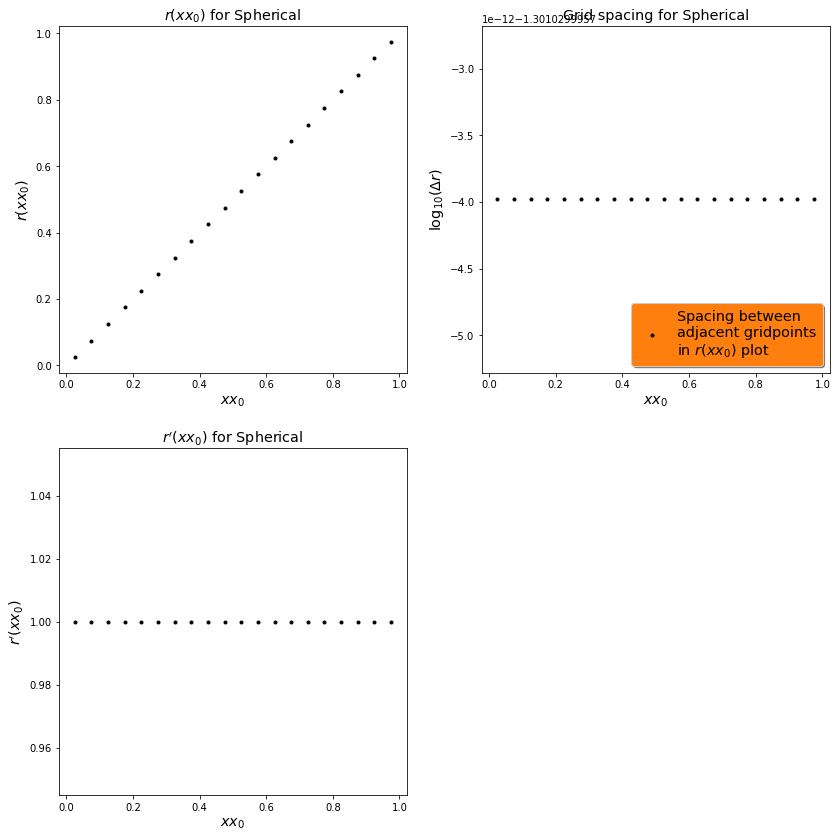

In [9]:
%matplotlib inline

import sympy as sp

import reference_metric as rfm
import NRPy_param_funcs as par
CoordSystem = "Spherical"
par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)
rfm.reference_metric()

RMAX     = 10.0
r_of_xx0      = sp.sympify(str(rfm.xxSph[0]                   ).replace("RMAX",str(RMAX)))
rprime_of_xx0 = sp.sympify(str(sp.diff(rfm.xxSph[0],rfm.xx[0])).replace("RMAX",str(RMAX)))

create_r_of_xx0_plots(CoordSystem, r_of_xx0,rprime_of_xx0)

<a id='sinhspherical'></a>

### Step 3.a.ii: **`reference_metric::CoordSystem = "SinhSpherical"`** \[Back to [top](#toc)\]
$$\label{sinhspherical}$$

Spherical coordinates, but with $$r(xx_0) = \text{AMPL} \frac{\sinh\left(\frac{xx_0}{\text{SINHW}}\right)}{\sinh\left(\frac{1}{\text{SINHW}}\right)}.$$

SinhSpherical uses two parameters: `AMPL` and `SINHW`. `AMPL` sets the outer boundary distance; and `SINHW` sets the focusing of the coordinate points near $r=0$, where a small `SINHW` ($\sim 0.125$) will greatly focus the points near $r=0$ and a large `SINHW` will look more like an ordinary spherical polar coordinate system.

In [10]:
if CoordSystem == "SinhSpherical":
    xxmin = [sp.sympify(0), sp.sympify(0), -M_PI]
    xxmax = [sp.sympify(1),          M_PI,  M_PI]

    AMPL, SINHW = par.Cparameters("REAL",thismodule,["AMPL","SINHW"],[10.0,0.2])
    # Set SinhSpherical radial coordinate by default; overwrite later if CoordSystem == "SinhSphericalv2".
    r = AMPL * (sp.exp(xx[0] / SINHW) - sp.exp(-xx[0] / SINHW)) / \
               (sp.exp(1 / SINHW) - sp.exp(-1 / SINHW))
    th = xx[1]
    ph = xx[2]

    Cart_to_xx[0] = SINHW*sp.asinh(sp.sqrt(Cartx ** 2 + Carty ** 2 + Cartz ** 2)*sp.sinh(1/SINHW)/AMPL)
    Cart_to_xx[1] = sp.acos(Cartz / sp.sqrt(Cartx ** 2 + Carty ** 2 + Cartz ** 2))
    Cart_to_xx[2] = sp.atan2(Carty, Cartx)
    
    xxSph[0] = r
    xxSph[1] = th
    xxSph[2] = ph

    # Now define xCart, yCart, and zCart in terms of x0,xx[1],xx[2].
    # Note that the relation between r and x0 is not necessarily trivial in SinhSpherical coordinates. See above.
    xxCart[0] = xxSph[0]*sp.sin(xxSph[1])*sp.cos(xxSph[2])
    xxCart[1] = xxSph[0]*sp.sin(xxSph[1])*sp.sin(xxSph[2])
    xxCart[2] = xxSph[0]*sp.cos(xxSph[1])

    scalefactor_orthog[0] = sp.diff(xxSph[0],xx[0])
    scalefactor_orthog[1] = xxSph[0]
    scalefactor_orthog[2] = xxSph[0]*sp.sin(xxSph[1])

    # Set the unit vectors
    UnitVectors = [[ sp.sin(xxSph[1])*sp.cos(xxSph[2]), sp.sin(xxSph[1])*sp.sin(xxSph[2]),  sp.cos(xxSph[1])],
                   [ sp.cos(xxSph[1])*sp.cos(xxSph[2]), sp.cos(xxSph[1])*sp.sin(xxSph[2]), -sp.sin(xxSph[1])],
                   [                 -sp.sin(xxSph[2]),                  sp.cos(xxSph[2]),  sp.sympify(0)   ]]

Now we explore $r(xx_0)$ for `SinhSpherical` assuming `AMPL=10.0` and `SINHW=0.2`:

<Figure size 432x288 with 0 Axes>

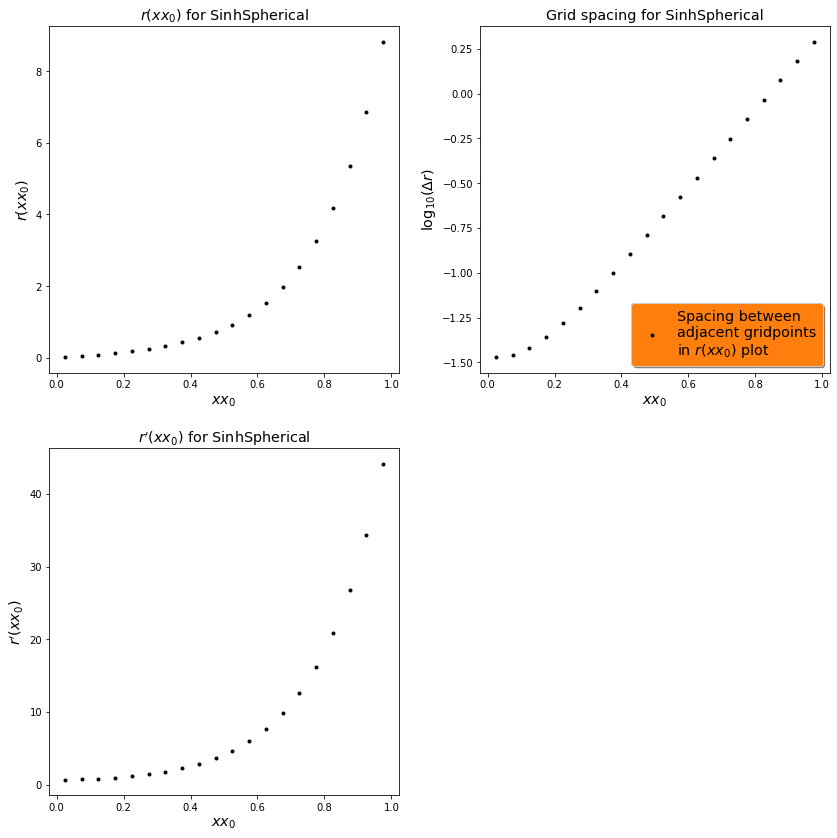

In [11]:
%matplotlib inline

import sympy as sp

import reference_metric as rfm
import NRPy_param_funcs as par
CoordSystem = "SinhSpherical"
par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)
rfm.reference_metric()

AMPL     = 10.0
SINHW    = 0.2
r_of_xx0      = sp.sympify(str(rfm.xxSph[0]                   ).replace("AMPL",str(AMPL)).replace("SINHW",str(SINHW)))
rprime_of_xx0 = sp.sympify(str(sp.diff(rfm.xxSph[0],rfm.xx[0])).replace("AMPL",str(AMPL)).replace("SINHW",str(SINHW)))

create_r_of_xx0_plots(CoordSystem, r_of_xx0,rprime_of_xx0)

<a id='sinhsphericalv2'></a>

### Step 3.a.iii: **`reference_metric::CoordSystem = "SinhSphericalv2"`** \[Back to [top](#toc)\]
$$\label{sinhsphericalv2}$$

The same as SinhSpherical coordinates, but with an additional `AMPL*const_dr*xx_0` term:
$$r(xx_0) = \text{AMPL} \left[\text{const_dr}\ xx_0 + \frac{\sinh\left(\frac{xx_0}{\text{SINHW}}\right)}{\sinh\left(\frac{1}{\text{SINHW}}\right)}\right].$$

In [12]:
if CoordSystem == "SinhSphericalv2":
    # SinhSphericalv2 adds the parameter "const_dr", which allows for a region near xx[0]=0 to have
    # constant radial resolution of const_dr, provided the sinh() term does not dominate near xx[0]=0.
    xxmin = [sp.sympify(0), sp.sympify(0), -M_PI]
    xxmax = [sp.sympify(1),          M_PI,  M_PI]

    AMPL, SINHW = par.Cparameters("REAL",thismodule,["AMPL","SINHW"],[10.0,0.2])
    const_dr = par.Cparameters("REAL",thismodule,["const_dr"],0.0625)

    r = AMPL*( const_dr*xx[0] + (sp.exp(xx[0] / SINHW) - sp.exp(-xx[0] / SINHW)) /
               (sp.exp(1 / SINHW) - sp.exp(-1 / SINHW)) )
    th = xx[1]
    ph = xx[2]

    # NO CLOSED-FORM EXPRESSION FOR RADIAL INVERSION.
    # Cart_to_xx[0] = "NewtonRaphson"
    # Cart_to_xx[1] = sp.acos(Cartz / sp.sqrt(Cartx ** 2 + Carty ** 2 + Cartz ** 2))
    # Cart_to_xx[2] = sp.atan2(Carty, Cartx)
    
    xxSph[0] = r
    xxSph[1] = th
    xxSph[2] = ph

    # Now define xCart, yCart, and zCart in terms of x0,xx[1],xx[2].
    # Note that the relation between r and x0 is not necessarily trivial in SinhSpherical coordinates. See above.
    xxCart[0] = xxSph[0]*sp.sin(xxSph[1])*sp.cos(xxSph[2])
    xxCart[1] = xxSph[0]*sp.sin(xxSph[1])*sp.sin(xxSph[2])
    xxCart[2] = xxSph[0]*sp.cos(xxSph[1])

    scalefactor_orthog[0] = sp.diff(xxSph[0],xx[0])
    scalefactor_orthog[1] = xxSph[0]
    scalefactor_orthog[2] = xxSph[0]*sp.sin(xxSph[1])

    # Set the unit vectors
    UnitVectors = [[ sp.sin(xxSph[1])*sp.cos(xxSph[2]), sp.sin(xxSph[1])*sp.sin(xxSph[2]),  sp.cos(xxSph[1])],
                   [ sp.cos(xxSph[1])*sp.cos(xxSph[2]), sp.cos(xxSph[1])*sp.sin(xxSph[2]), -sp.sin(xxSph[1])],
                   [                 -sp.sin(xxSph[2]),                  sp.cos(xxSph[2]),  sp.sympify(0)   ]]

Now we explore $r(xx_0)$ for `SinhSphericalv2` assuming `AMPL=10.0`, `SINHW=0.2`, and `const_dr=0.05`. Notice that the `const_dr` term significantly increases the grid spacing near $xx_0=0$ relative to `SinhSpherical` coordinates.

<Figure size 432x288 with 0 Axes>

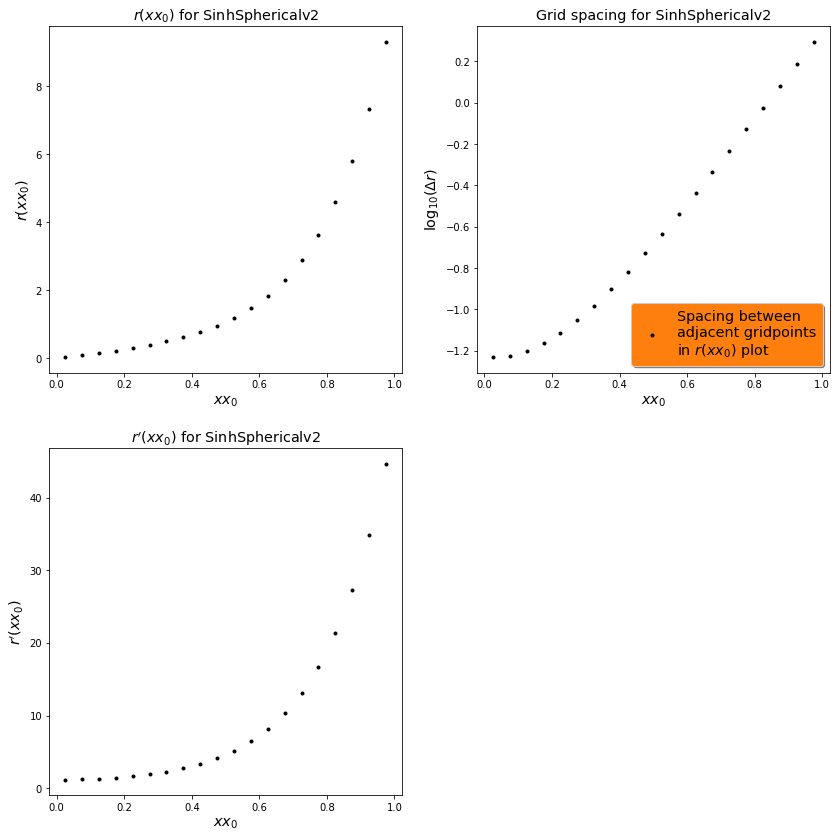

In [13]:
%matplotlib inline

import sympy as sp

import reference_metric as rfm
import NRPy_param_funcs as par
CoordSystem = "SinhSphericalv2"
par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)
rfm.reference_metric()

AMPL     = 10.0
SINHW    = 0.2
const_dr = 0.05
r_of_xx0      = sp.sympify(str(rfm.xxSph[0]                   ).replace("AMPL",str(AMPL)).replace("SINHW",str(SINHW)).replace("const_dr",str(const_dr)))
rprime_of_xx0 = sp.sympify(str(sp.diff(rfm.xxSph[0],rfm.xx[0])).replace("AMPL",str(AMPL)).replace("SINHW",str(SINHW)).replace("const_dr",str(const_dr)))

create_r_of_xx0_plots(CoordSystem, r_of_xx0,rprime_of_xx0)

<a id='cylindricallike'></a>

## Step 3.b: Cylindrical-like coordinate systems \[Back to [top](#toc)\]
$$\label{cylindricallike}$$

<a id='cylindrical'></a>

### Step 3.b.i: **`reference_metric::CoordSystem = "Cylindrical"`** \[Back to [top](#toc)\]
$$\label{cylindrical}$$

Standard cylindrical coordinates, with $(\rho,\phi,z)=(xx_0,xx_1,xx_2)$

In [14]:
if CoordSystem == "Cylindrical":
    # Assuming the cylindrical radial coordinate
    #   is positive makes nice simplifications of
    #   unit vectors possible.
    xx[0] = sp.symbols("xx0", real=True)
    
    RHOMAX,ZMIN,ZMAX = par.Cparameters("REAL",thismodule,["RHOMAX","ZMIN","ZMAX"],[10.0,-10.0,10.0])
    xxmin = [sp.sympify(0), -M_PI, ZMIN]
    xxmax = [       RHOMAX,  M_PI, ZMAX]

    RHOCYL = xx[0]
    PHICYL = xx[1]
    ZCYL   = xx[2]

    Cart_to_xx[0] = sp.sqrt(Cartx ** 2 + Carty ** 2)
    Cart_to_xx[1] = sp.atan2(Carty, Cartx)
    Cart_to_xx[2] = Cartz
    
    xxCart[0] = RHOCYL*sp.cos(PHICYL)
    xxCart[1] = RHOCYL*sp.sin(PHICYL)
    xxCart[2] = ZCYL

    xxSph[0] = sp.sqrt(RHOCYL**2 + ZCYL**2)
    xxSph[1] = sp.acos(ZCYL / xxSph[0])
    xxSph[2] = PHICYL

    scalefactor_orthog[0] = sp.diff(RHOCYL,xx[0])
    scalefactor_orthog[1] = RHOCYL
    scalefactor_orthog[2] = sp.diff(ZCYL,xx[2])

    # Set the unit vectors
    UnitVectors = [[ sp.cos(PHICYL), sp.sin(PHICYL), sp.sympify(0)],
                   [-sp.sin(PHICYL), sp.cos(PHICYL), sp.sympify(0)],
                   [ sp.sympify(0),  sp.sympify(0),  sp.sympify(1)]]

Next let's plot **"Cylindrical"** coordinates.

<Figure size 864x864 with 0 Axes>

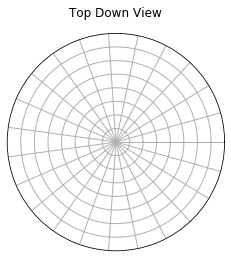

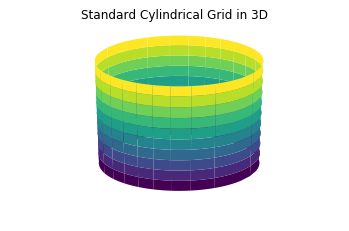

In [15]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

R = np.linspace(0, 2, 24)
h = 2
u = np.linspace(0,  2*np.pi, 24)

x = np.outer(R, np.cos(u))
y = np.outer(R, np.sin(u))
z = h * np.outer(np.ones(np.size(u)), np.ones(np.size(u)))

r = np.arange(0,2,0.25)
theta = 2*np.pi*r*0

fig = plt.figure(figsize=(12,12)) # 8 in x 8 in
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1 = plt.axes(projection='polar')

ax1.set_rmax(2)

ax1.set_rgrids(r,labels=[])

thetas = np.linspace(0,360,24, endpoint=True)
ax1.set_thetagrids(thetas,labels=[])

# ax.grid(True)
ax1.grid(True,linewidth='1.0')
ax1.set_title("Top Down View")
plt.show()

ax2 = plt.axes(projection='3d', xticklabels=[], yticklabels=[], zticklabels=[])
#ax2.plot_surface(x,y,z, alpha=.75, cmap = 'viridis') # z in case of disk which is parallel to XY plane is constant and you can directly use h

x=np.linspace(-2, 2, 100)
z=np.linspace(-2, 2, 100)
Xc, Zc=np.meshgrid(x, z)
Yc = np.sqrt(4-Xc**2)

rstride = 10
cstride = 10
ax2.plot_surface(Xc, Yc, Zc, alpha=1.0, rstride=rstride, cstride=cstride, cmap = 'viridis')
ax2.plot_surface(Xc, -Yc, Zc, alpha=1.0, rstride=rstride, cstride=cstride, cmap = 'viridis')
ax2.set_title("Standard Cylindrical Grid in 3D")
ax2.grid(False)
plt.axis('off')

plt.show()

<a id='sinhcylindrical'></a>

### Step 3.b.ii" **`reference_metric::CoordSystem = "SinhCylindrical"`** \[Back to [top](#toc)\]
$$\label{sinhcylindrical}$$

Cylindrical coordinates, but with
$$\rho(xx_0) = \text{AMPLRHO} \frac{\sinh\left(\frac{xx_0}{\text{SINHWRHO}}\right)}{\sinh\left(\frac{1}{\text{SINHWRHO}}\right)}$$
and 
$$z(xx_2) = \text{AMPLZ} \frac{\sinh\left(\frac{xx_2}{\text{SINHWZ}}\right)}{\sinh\left(\frac{1}{\text{SINHWZ}}\right)}$$

In [16]:
if CoordSystem == "SinhCylindrical":
    # Assuming the cylindrical radial coordinate
    #   is positive makes nice simplifications of
    #   unit vectors possible.
    xx[0] = sp.symbols("xx0", real=True)
    
    xxmin = [sp.sympify(0), -M_PI, sp.sympify(-1)]
    xxmax = [sp.sympify(1),  M_PI, sp.sympify(+1)]

    AMPLRHO, SINHWRHO, AMPLZ, SINHWZ = par.Cparameters("REAL",thismodule,
                                                       ["AMPLRHO","SINHWRHO","AMPLZ","SINHWZ"],
                                                       [     10.0,       0.2,   10.0,    0.2])

    # Set SinhCylindrical radial & z coordinates by default; overwrite later if CoordSystem == "SinhCylindricalv2".
    RHOCYL = AMPLRHO * (sp.exp(xx[0] / SINHWRHO) - sp.exp(-xx[0] / SINHWRHO)) / (sp.exp(1 / SINHWRHO) - sp.exp(-1 / SINHWRHO))
    # phi coordinate remains unchanged.
    PHICYL = xx[1]
    ZCYL   = AMPLZ   * (sp.exp(xx[2] / SINHWZ)   - sp.exp(-xx[2] / SINHWZ))   / (sp.exp(1 / SINHWZ)   - sp.exp(-1 / SINHWZ))
    Cart_to_xx[0] = SINHWRHO*sp.asinh(sp.sqrt(Cartx ** 2 + Carty ** 2)*sp.sinh(1/SINHWRHO)/AMPLRHO)
    Cart_to_xx[1] = sp.atan2(Carty, Cartx)
    Cart_to_xx[2] = SINHWZ*sp.asinh(Cartz*sp.sinh(1/SINHWZ)/AMPLZ)
    
    xxCart[0] = RHOCYL*sp.cos(PHICYL)
    xxCart[1] = RHOCYL*sp.sin(PHICYL)
    xxCart[2] = ZCYL

    xxSph[0] = sp.sqrt(RHOCYL**2 + ZCYL**2)
    xxSph[1] = sp.acos(ZCYL / xxSph[0])
    xxSph[2] = PHICYL

    scalefactor_orthog[0] = sp.diff(RHOCYL,xx[0])
    scalefactor_orthog[1] = RHOCYL
    scalefactor_orthog[2] = sp.diff(ZCYL,xx[2])

    # Set the unit vectors
    UnitVectors = [[ sp.cos(PHICYL), sp.sin(PHICYL), sp.sympify(0)],
                   [-sp.sin(PHICYL), sp.cos(PHICYL), sp.sympify(0)],
                   [ sp.sympify(0),  sp.sympify(0),  sp.sympify(1)]]

Next let's plot **"SinhCylindrical"** coordinates.

<Figure size 432x288 with 0 Axes>

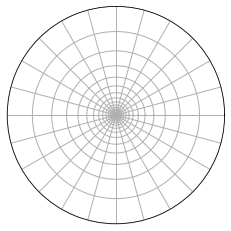

In [17]:
fig=plt.figure()


plt.clf()

fig = plt.figure()

ax = plt.subplot(1,1,1, projection='polar')

ax.set_rmax(2)

Nr = 20
xx0s = np.linspace(0,2,Nr, endpoint=True) + 1.0/(2.0*Nr)

rs = []
AMPLRHO = 1.0
SINHW = 0.4
for i in range(Nr):
    rs.append(AMPLRHO * (np.exp(xx0s[i] / SINHW) - np.exp(-xx0s[i] / SINHW)) / \
                        (np.exp(1.0 / SINHW) - np.exp(-1.0 / SINHW)))

ax.set_rgrids(rs,labels=[])

thetas = np.linspace(0,360,25, endpoint=True)
ax.set_thetagrids(thetas,labels=[])

# ax.grid(True)
ax.grid(True,linewidth='1.0')

plt.show()



<a id='sinhcylindricalv2'></a>

### Step 3.b.iii: **`reference_metric::CoordSystem = "SinhCylindricalv2"`** \[Back to [top](#toc)\]
$$\label{sinhcylindricalv2}$$

Cylindrical coordinates, but with
$$\rho(xx_0) = \text{AMPLRHO} \left[\text{const_drho}\ xx_0 + \frac{\sinh\left(\frac{xx_0}{\text{SINHWRHO}}\right)}{\sinh\left(\frac{1}{\text{SINHWRHO}}\right)}\right]$$
and 
$$z(xx_2) = \text{AMPLZ} \left[\text{const_dz}\ xx_2 + \frac{\sinh\left(\frac{xx_2}{\text{SINHWZ}}\right)}{\sinh\left(\frac{1}{\text{SINHWZ}}\right)}\right]$$

In [18]:
if CoordSystem == "SinhCylindricalv2":
    # Assuming the cylindrical radial coordinate
    #   is positive makes nice simplifications of
    #   unit vectors possible.
    xx[0] = sp.symbols("xx0", real=True)

    # SinhCylindricalv2 adds the parameters "const_drho", "const_dz", which allows for regions near xx[0]=0
    # and xx[2]=0 to have constant rho and z resolution of const_drho and const_dz, provided the sinh() terms
    # do not dominate near xx[0]=0 and xx[2]=0.
    xxmin = [sp.sympify(0), -M_PI, sp.sympify(-1)]
    xxmax = [sp.sympify(1),  M_PI, sp.sympify(+1)]
    AMPLRHO, SINHWRHO, AMPLZ, SINHWZ = par.Cparameters("REAL",thismodule,
                                                       ["AMPLRHO","SINHWRHO","AMPLZ","SINHWZ"],
                                                       [     10.0,       0.2,   10.0,    0.2])
    const_drho, const_dz = par.Cparameters("REAL",thismodule,["const_drho","const_dz"],[0.0625,0.0625])

    RHOCYL = AMPLRHO * ( const_drho*xx[0] + (sp.exp(xx[0] / SINHWRHO) - sp.exp(-xx[0] / SINHWRHO)) / (sp.exp(1 / SINHWRHO) - sp.exp(-1 / SINHWRHO)) )
    PHICYL = xx[1]
    ZCYL   = AMPLZ   * ( const_dz  *xx[2] + (sp.exp(xx[2] / SINHWZ  ) - sp.exp(-xx[2] / SINHWZ  )) / (sp.exp(1 / SINHWZ  ) - sp.exp(-1 / SINHWZ  )) )

    # NO CLOSED-FORM EXPRESSION FOR RADIAL OR Z INVERSION.
    # Cart_to_xx[0] = "NewtonRaphson"
    # Cart_to_xx[1] = sp.atan2(Carty, Cartx)
    # Cart_to_xx[2] = "NewtonRaphson"

    xxCart[0] = RHOCYL*sp.cos(PHICYL)
    xxCart[1] = RHOCYL*sp.sin(PHICYL)
    xxCart[2] = ZCYL

    xxSph[0] = sp.sqrt(RHOCYL**2 + ZCYL**2)
    xxSph[1] = sp.acos(ZCYL / xxSph[0])
    xxSph[2] = PHICYL

    scalefactor_orthog[0] = sp.diff(RHOCYL,xx[0])
    scalefactor_orthog[1] = RHOCYL
    scalefactor_orthog[2] = sp.diff(ZCYL,xx[2])

    # Set the unit vectors
    UnitVectors = [[ sp.cos(PHICYL), sp.sin(PHICYL), sp.sympify(0)],
                   [-sp.sin(PHICYL), sp.cos(PHICYL), sp.sympify(0)],
                   [ sp.sympify(0),  sp.sympify(0),  sp.sympify(1)]]

For example, let's set up **`SinhCylindricalv2`** coordinates and output the Christoffel symbol $\hat{\Gamma}^{xx_2}_{xx_2 xx_2}$, or more simply $\hat{\Gamma}^2_{22}$:

In [19]:
par.set_parval_from_str("reference_metric::CoordSystem","SinhCylindricalv2")

rfm.reference_metric()

sp.pretty_print(sp.simplify(rfm.GammahatUDD[2][2][2]))

                         ⎛ 2⋅xx₂     ⎞    1                             
                         ⎜ ──────    ⎟  ──────                          
                         ⎜ SINHWZ    ⎟  SINHWZ                          
                        -⎝ℯ       - 1⎠⋅ℯ                                
────────────────────────────────────────────────────────────────────────
       ⎛                  ⎛   2       ⎞   xx₂     ⎛ 2⋅xx₂     ⎞    1   ⎞
       ⎜                  ⎜ ──────    ⎟  ──────   ⎜ ──────    ⎟  ──────⎟
       ⎜                  ⎜ SINHWZ    ⎟  SINHWZ   ⎜ SINHWZ    ⎟  SINHWZ⎟
SINHWZ⋅⎝- SINHWZ⋅const_dz⋅⎝ℯ       - 1⎠⋅ℯ       - ⎝ℯ       + 1⎠⋅ℯ      ⎠


As we will soon see, defining these "hatted" quantities will be quite useful when expressing hyperbolic ([wave-equation](https://en.wikipedia.org/wiki/Wave_equation)-like) PDEs in non-Cartesian coordinate systems.

<a id='cartesianlike'></a>

## Step 3.c: Cartesian-like coordinate systems \[Back to [top](#toc)\]
$$\label{cartesianlike}$$

<a id='cartesian'></a>

### Step 3.c.i: **`reference_metric::CoordSystem = "Cartesian"`** \[Back to [top](#toc)\]
$$\label{cartesian}$$

Standard Cartesian coordinates, with $(x,y,z)=$ `(xx0,xx1,xx2)`

In [20]:
if CoordSystem == "Cartesian":        
    xmin, xmax, ymin, ymax, zmin, zmax = par.Cparameters("REAL",thismodule,
                                                         ["xmin","xmax","ymin","ymax","zmin","zmax"],
                                                         [ -10.0,  10.0, -10.0,  10.0, -10.0,  10.0])
    xxmin = ["xmin", "ymin", "zmin"]
    xxmax = ["xmax", "ymax", "zmax"]

    xxCart[0] = xx[0]
    xxCart[1] = xx[1]
    xxCart[2] = xx[2]

    xxSph[0] = sp.sqrt(xx[0] ** 2 + xx[1] ** 2 + xx[2] ** 2)
    xxSph[1] = sp.acos(xx[2] / xxSph[0])
    xxSph[2] = sp.atan2(xx[1], xx[0])

    Cart_to_xx[0] = Cartx
    Cart_to_xx[1] = Carty
    Cart_to_xx[2] = Cartz

    scalefactor_orthog[0] = sp.sympify(1)
    scalefactor_orthog[1] = sp.sympify(1)
    scalefactor_orthog[2] = sp.sympify(1)

    # Set the transpose of the matrix of unit vectors
    UnitVectors = [[sp.sympify(1), sp.sympify(0), sp.sympify(0)],
                   [sp.sympify(0), sp.sympify(1), sp.sympify(0)],
                   [sp.sympify(0), sp.sympify(0), sp.sympify(1)]]

<Figure size 432x288 with 0 Axes>

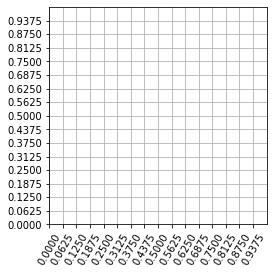

In [21]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.clf()

fig = plt.figure()
ax = fig.gca()
Nx = 16
ax.set_xticks(np.arange(0, 1., 1./Nx))
ax.set_yticks(np.arange(0, 1., 1./Nx))

for tick in ax.get_xticklabels():
    tick.set_rotation(60)

# plt.scatter(x, y)
ax.set_aspect('equal')

plt.grid()

# plt.savefig("Cartgrid.png",dpi=300)
plt.show()
# plt.close(fig)

<a id='cartesian'></a>

### Step 3.c.ii: **`reference_metric::CoordSystem = "SinhCartesian"`** \[Back to [top](#toc)\]
$$\label{cartesian}$$

In this coordinate system, all three coordinates behave like the $z$-coordinate in SinhCylindrical coordinates, i.e.

$$
\begin{align}
x(xx_0) &= \text{AMPLX} \left[\frac{\sinh\left(\frac{xx_0}{\text{SINHWZ}}\right)}{\sinh\left(\frac{1}{\text{SINHWX}}\right)}\right]\ ,\\
y(xx_1) &= \text{AMPLY} \left[\frac{\sinh\left(\frac{xx_1}{\text{SINHWZ}}\right)}{\sinh\left(\frac{1}{\text{SINHWY}}\right)}\right]\ ,\\
z(xx_2) &= \text{AMPLZ} \left[\frac{\sinh\left(\frac{xx_2}{\text{SINHWZ}}\right)}{\sinh\left(\frac{1}{\text{SINHWZ}}\right)}\right]\ .
\end{align}
$$

In [22]:
if CoordSystem == "SinhCartesian":
    
    # SinhCartesian coordinates allows us to push the outer boundary of the
    # computational domain a lot further away, while keeping reasonably high
    # resolution towards the center of the computational grid.
    
    # Set default values for min and max (x,y,z)
    xxmin = [sp.sympify(-1), sp.sympify(-1), sp.sympify(-1)]
    xxmax = [sp.sympify(+1), sp.sympify(+1), sp.sympify(+1)]
    
    # Declare basic parameters of the coordinate system and their default values
    AMPLX,SINHWX,AMPLY,SINHWY,AMPLZ,SINHWZ = par.Cparameters("REAL",thismodule,
                                                            ["AMPLX","SINHWX","AMPLY","SINHWY","AMPLZ","SINHWZ"],
                                                            [   10.0,     0.2,   10.0,     0.2,   10.0,     0.2])

    # Compute (xxCart0,xxCart1,xxCart2) from (xx0,xx1,xx2)
    xxCart[0] = AMPLX*(sp.exp(xx[0]/SINHWX) - sp.exp(-xx[0]/SINHWX))/(sp.exp(1/SINHWX) - sp.exp(-1/SINHWX))
    xxCart[1] = AMPLY*(sp.exp(xx[1]/SINHWY) - sp.exp(-xx[1]/SINHWY))/(sp.exp(1/SINHWY) - sp.exp(-1/SINHWY))
    xxCart[2] = AMPLZ*(sp.exp(xx[2]/SINHWZ) - sp.exp(-xx[2]/SINHWZ))/(sp.exp(1/SINHWZ) - sp.exp(-1/SINHWZ))

    # Compute (r,th,ph) from (xxCart2,xxCart1,xxCart2)
    xxSph[0] = sp.sqrt(xxCart[0] ** 2 + xxCart[1] ** 2 + xxCart[2] ** 2)
    xxSph[1] = sp.acos(xxCart[2] / xxSph[0])
    xxSph[2] = sp.atan2(xxCart[1], xxCart[0])

    # Compute (xx0,xx1,xx2) from (Cartx,Carty,Cartz)
    Cart_to_xx[0] = SINHWX*sp.asinh(AMPLX*Cartx*(sp.exp(1/SINHWX) - sp.exp(-1/SINHWX))/2)
    Cart_to_xx[1] = SINHWY*sp.asinh(AMPLY*Carty*(sp.exp(1/SINHWY) - sp.exp(-1/SINHWY))/2)
    Cart_to_xx[2] = SINHWZ*sp.asinh(AMPLZ*Cartz*(sp.exp(1/SINHWZ) - sp.exp(-1/SINHWZ))/2)

    # Compute scale factors
    scalefactor_orthog[0] = sp.diff(xxCart[0],xx[0])
    scalefactor_orthog[1] = sp.diff(xxCart[1],xx[1])
    scalefactor_orthog[2] = sp.diff(xxCart[2],xx[2])

    # Set the transpose of the matrix of unit vectors
    UnitVectors = [[sp.sympify(1), sp.sympify(0), sp.sympify(0)],
                   [sp.sympify(0), sp.sympify(1), sp.sympify(0)],
                   [sp.sympify(0), sp.sympify(0), sp.sympify(1)]]

<Figure size 432x288 with 0 Axes>

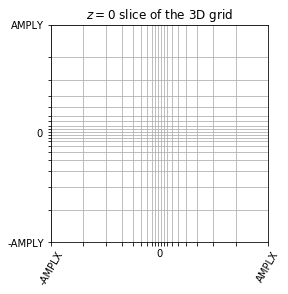

In [23]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.clf()

fig = plt.figure()
ax = fig.gca()

# Set plot title
ax.set_title(r"$z=0$ slice of the 3D grid")

# Set SINH parameters. Here we assume:
#
# AMPLX  = AMPLY  = SINHA
# SINHWX = SINHWY = SINHW
SINHA = 10.0
SINHW = 0.3

# Set number of points. We assume the same point
# distribution along the (x,y)-directions
Nxxs = 20
xxis = np.linspace(-1,1,Nxxs, endpoint=True)

# Compute axis ticks by evaluating x and y using SinhCartesian coordinates
axis_ticks = []
for i in range(Nxxs):
    axis_ticks.append(SINHA * (np.exp(xxis[i] / SINHW) - np.exp(-xxis[i] / SINHW)) / \
                        (np.exp(1.0 / SINHW) - np.exp(-1.0 / SINHW)))

# Set the axis ticks
ax.set_xticks(axis_ticks)
ax.set_yticks(axis_ticks)

# Set x and y labels. Initialize array with empty strings
labelsx = ["" for i in range(Nxxs)]
labelsy = ["" for i in range(Nxxs)]

# Set x_min and x_max tick label
labelsx[0] = r"-AMPLX"
labelsx[-1] = r"AMPLX"

# Set y_min and y_max tick label
labelsy[0] = r"-AMPLY"
labelsy[-1] = r"AMPLY"

# Set tick labels
ax.set_xticklabels(labelsx)
ax.set_yticklabels(labelsy)

# Rotate x labels by 60 degrees
for tick in ax.get_xticklabels():
    tick.set_rotation(60)

# Draw the x=0 and y=0 ticklabel
ax.text(0,-11,"0",ha="center",va="center")
ax.text(-11,0,"0",ha="center",va="center")

# plt.scatter(x, y)
ax.set_aspect('equal')

plt.grid()

# plt.savefig("Cartgrid.png",dpi=300)
plt.show()
# plt.close(fig)

<a id='prolatespheroidal'></a>

## Step 3.d: [Prolate spheroidal](https://en.wikipedia.org/wiki/Prolate_spheroidal_coordinates)-like coordinate systems \[Back to [top](#toc)\]
$$\label{prolatespheroidal}$$

<a id='symtp'></a>

### Step 3.d.i: **`reference_metric::CoordSystem = "SymTP"`** \[Back to [top](#toc)\]
$$\label{symtp}$$

Symmetric TwoPuncture coordinates, with $(\rho,\phi,z)=(xx_0\sin(xx_1), xx_2, \sqrt{xx_0^2 + \text{bScale}^2}\cos(xx_1))$

In [24]:
if CoordSystem == "SymTP":
    
    var1, var2= sp.symbols('var1 var2',real=True)
    bScale, AW, AMAX, RHOMAX, ZMIN, ZMAX = par.Cparameters("REAL",thismodule,
                                                           ["bScale","AW","AMAX","RHOMAX","ZMIN","ZMAX"],
                                                           [0.5,     0.2,   10.0,    10.0, -10.0,  10.0])

    # Assuming xx0, xx1, and bScale
    #   are positive makes nice simplifications of
    #   unit vectors possible.
    xx[0],xx[1] = sp.symbols("xx0 xx1", real=True)

    xxmin = [sp.sympify(0), sp.sympify(0),-M_PI]
    xxmax = [         AMAX,          M_PI, M_PI]

    AA = xx[0]

    if CoordSystem == "SinhSymTP":
        AA = (sp.exp(xx[0]/AW)-sp.exp(-xx[0]/AW))/2

    var1 = sp.sqrt(AA**2 + (bScale * sp.sin(xx[1]))**2)
    var2 = sp.sqrt(AA**2 + bScale**2)

    RHOSYMTP = AA*sp.sin(xx[1])
    PHSYMTP = xx[2]
    ZSYMTP = var2*sp.cos(xx[1])

    xxCart[0] = AA  *sp.sin(xx[1])*sp.cos(xx[2])
    xxCart[1] = AA  *sp.sin(xx[1])*sp.sin(xx[2])
    xxCart[2] = ZSYMTP

    xxSph[0] = sp.sqrt(RHOSYMTP**2 + ZSYMTP**2)
    xxSph[1] = sp.acos(ZSYMTP / xxSph[0])
    xxSph[2] = PHSYMTP

    rSph  = sp.sqrt(Cartx ** 2 + Carty ** 2 + Cartz ** 2)
    thSph = sp.acos(Cartz / rSph)
    phSph = sp.atan2(Carty, Cartx)

    # Mathematica script to compute Cart_to_xx[]
    #             AA = x1;
    #             var2 = Sqrt[AA^2 + bScale^2];
    #             RHOSYMTP = AA*Sin[x2];
    #             ZSYMTP = var2*Cos[x2];
    #             Solve[{rSph == Sqrt[RHOSYMTP^2 + ZSYMTP^2],
    #                    thSph == ArcCos[ZSYMTP/Sqrt[RHOSYMTP^2 + ZSYMTP^2]],
    #                    phSph == x3}, 
    #                   {x1, x2, x3}]
    Cart_to_xx[0] = sp.sqrt(-bScale**2 + rSph**2 + 
                            sp.sqrt(bScale**4 + 2*bScale**2*rSph**2 + rSph**4 - 
                                    4*bScale**2*rSph**2*sp.cos(thSph)**2))*M_SQRT1_2 # M_SQRT1_2 = 1/sqrt(2); define this way for UnitTesting

    # The sign() function in the following expression ensures the correct root is taken.
    Cart_to_xx[1] = sp.acos(sp.sign(Cartz)*(
                              sp.sqrt(1 + rSph**2/bScale**2 - 
                                      sp.sqrt(bScale**4 + 2*bScale**2*rSph**2 + rSph**4 - 
                                              4*bScale**2*rSph**2*sp.cos(thSph)**2)/bScale**2)*M_SQRT1_2)) # M_SQRT1_2 = 1/sqrt(2); define this way for UnitTesting

    Cart_to_xx[2] = phSph

<a id='sinhsymtp'></a>

### Step 3.d.ii: **`reference_metric::CoordSystem = "SinhSymTP"`** \[Back to [top](#toc)\]
$$\label{sinhsymtp}$$

Symmetric TwoPuncture coordinates, but with $$xx_0 \to \sinh(xx_0/\text{AW})$$

In [25]:
if CoordSystem == "SinhSymTP":
    
    var1, var2= sp.symbols('var1 var2',real=True)
    bScale, AW, AMAX, RHOMAX, ZMIN, ZMAX = par.Cparameters("REAL",thismodule,
                                                           ["bScale","AW","AMAX","RHOMAX","ZMIN","ZMAX"],
                                                           [0.5,     0.2,   10.0,    10.0, -10.0,  10.0])

    # Assuming xx0, xx1, and bScale
    #   are positive makes nice simplifications of
    #   unit vectors possible.
    xx[0],xx[1] = sp.symbols("xx0 xx1", real=True)

    xxmin = [sp.sympify(0), sp.sympify(0),-M_PI]
    xxmax = [         AMAX,          M_PI, M_PI]

    AA = xx[0]

    if CoordSystem == "SinhSymTP":
        # With xxmax[0] == AMAX, sinh(xx0/AMAX) will evaluate to a number between 0 and 1.
        #   Similarly, sinh(xx0/(AMAX*SINHWAA)) / sinh(1/SINHWAA) will also evaluate to a number between 0 and 1.
        #   Then AA = AMAX*sinh(xx0/(AMAX*SINHWAA)) / sinh(1/SINHWAA) will evaluate to a number between 0 and AMAX.
        AA = AMAX * (sp.exp(xx[0] / (AMAX*SINHWAA)) - sp.exp(-xx[0] / (AMAX*SINHWAA))) / (sp.exp(1 / SINHWAA) - sp.exp(-1 / AMAX))
    
    var1 = sp.sqrt(AA**2 + (bScale * sp.sin(xx[1]))**2)
    var2 = sp.sqrt(AA**2 + bScale**2)

    RHOSYMTP = AA*sp.sin(xx[1])
    PHSYMTP = xx[2]
    ZSYMTP = var2*sp.cos(xx[1])

    xxCart[0] = AA  *sp.sin(xx[1])*sp.cos(xx[2])
    xxCart[1] = AA  *sp.sin(xx[1])*sp.sin(xx[2])
    xxCart[2] = ZSYMTP

    xxSph[0] = sp.sqrt(RHOSYMTP**2 + ZSYMTP**2)
    xxSph[1] = sp.acos(ZSYMTP / xxSph[0])
    xxSph[2] = PHSYMTP

    scalefactor_orthog[0] = sp.diff(AA,xx[0]) * var1 / var2
    scalefactor_orthog[1] = var1
    scalefactor_orthog[2] = AA * sp.sin(xx[1])

    # Set the transpose of the matrix of unit vectors
    UnitVectors = [[sp.sin(xx[1]) * sp.cos(xx[2]) * var2 / var1,
                    sp.sin(xx[1]) * sp.sin(xx[2]) * var2 / var1,
                    AA * sp.cos(xx[1]) / var1],
                   [AA * sp.cos(xx[1]) * sp.cos(xx[2]) / var1,
                    AA * sp.cos(xx[1]) * sp.sin(xx[2]) / var1,
                        -sp.sin(xx[1]) * var2 / var1],
                   [-sp.sin(xx[2]), sp.cos(xx[2]), sp.sympify(0)]]

<a id='latex_pdf_output'></a>

# Step 4: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Reference_Metric.pdf](Tutorial-Reference_Metric.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [26]:
!jupyter nbconvert --to latex --template latex_nrpy_style.tplx --log-level='WARN' Tutorial-Reference_Metric.ipynb
!pdflatex -interaction=batchmode Tutorial-Reference_Metric.tex
!pdflatex -interaction=batchmode Tutorial-Reference_Metric.tex
!pdflatex -interaction=batchmode Tutorial-Reference_Metric.tex
!rm -f Tut*.out Tut*.aux Tut*.log

This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
